In [1]:
# Function to generate wordclouds for each OEM
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud, STOPWORDS



In [2]:
df = pd.read_csv("ford_pass_car_apps_reviews.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   app_name     10000 non-null  object
 1   review_text  9998 non-null   object
 2   review_date  10000 non-null  object
 3   rating       10000 non-null  int64 
 4   app_version  9667 non-null   object
 5   thumbs_up    10000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 468.9+ KB


In [4]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import math

def plot_wordclouds_grid_by_oem(df, text_col, oem_col):
    """
    Generate and display wordclouds for each OEM in a single large figure.
    """
    custom_stopwords = set(STOPWORDS).union({'app', 'car', 'work', 'vehicle', 'Ford','Tesla'})
    oems = df[oem_col].unique()
    n = len(oems)
    cols = 2  # You can change this for more/less columns
    rows = math.ceil(n / cols)
    plt.figure(figsize=(cols * 8, rows * 6))
    for i, oem in enumerate(oems, 1):
        text = " ".join(df[df[oem_col] == oem][text_col].astype(str))
        wc = WordCloud(width=1200, height=600, background_color='white', stopwords=custom_stopwords).generate(text)
        plt.subplot(rows, cols, i)
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"WordCloud for {oem}", fontsize=18)
    plt.tight_layout()
    plt.show()

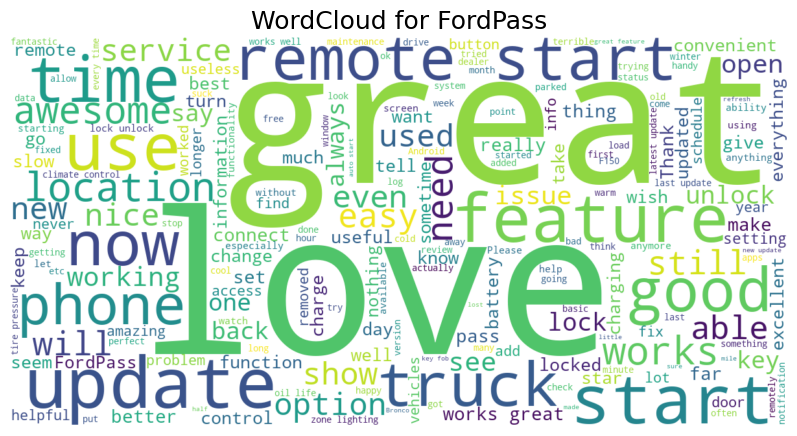

In [5]:
# Filter for Ford Pass only
ford_df = df[df['app_name'] == 'FordPass']
plot_wordclouds_grid_by_oem(ford_df, 'review_text', 'app_name')

## Topic Modeling for Ford Pass
We will use Latent Dirichlet Allocation (LDA) to extract topics from the reviews for Ford Pass.

### What is CountVectorizer?

CountVectorizer is a tool from scikit-learn that converts a collection of text documents into a matrix of token (word) counts. Each row represents a document, and each column represents a unique word from all documents. The value in each cell is the number of times that word appears in the document.


**Example:**
Suppose we have these two sentences:

1. "I love my car"
2. "I love your car"

Using CountVectorizer, we get this matrix:

|      | car | love | my | your |
|------|-----|------|----|------|
| Doc1 |  1  |  1   | 1  |  0   |
| Doc2 |  1  |  1   | 0  |  1   |

So, each document is now represented as a vector of word counts, which can be used for machine learning models.

#### What do `max_df` and `min_df` mean in CountVectorizer?

- **max_df**: This parameter ignores words that appear in more than a certain fraction of documents. For example, `max_df=0.95` means any word that appears in more than 95% of documents will be ignored. This helps remove very common words that are unlikely to be useful (like "the", "and").

- **min_df**: This parameter ignores words that appear in fewer than a certain number (or fraction) of documents. For example, `min_df=2` means any word that appears in fewer than 2 documents will be ignored. This helps remove rare words that may be typos or not useful for analysis.


These parameters help focus the analysis on words that are neither too common nor too rare.

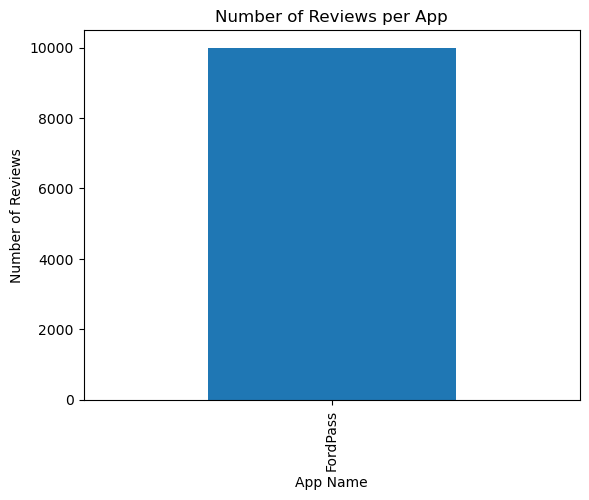

In [6]:
df['app_name'].value_counts().plot(kind='bar',xlabel='App Name', ylabel='Number of Reviews', title='Number of Reviews per App')
plt.show()

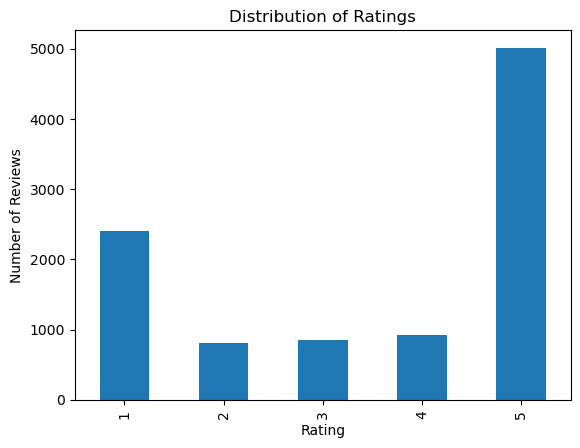

In [7]:
df['rating'].value_counts().sort_index().plot(kind='bar',xlabel='Rating', ylabel='Number of Reviews', title='Distribution of Ratings')
plt.show()

/var/folders/ys/rh_m_lvd12bc1py05dbf4g5m0000gn/T/ipykernel_57283/164534812.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.dropna(subset=['review_date']).groupby([pd.Grouper(key='review_date', freq='M'), 'app_name'])['rating'].mean().reset_index()


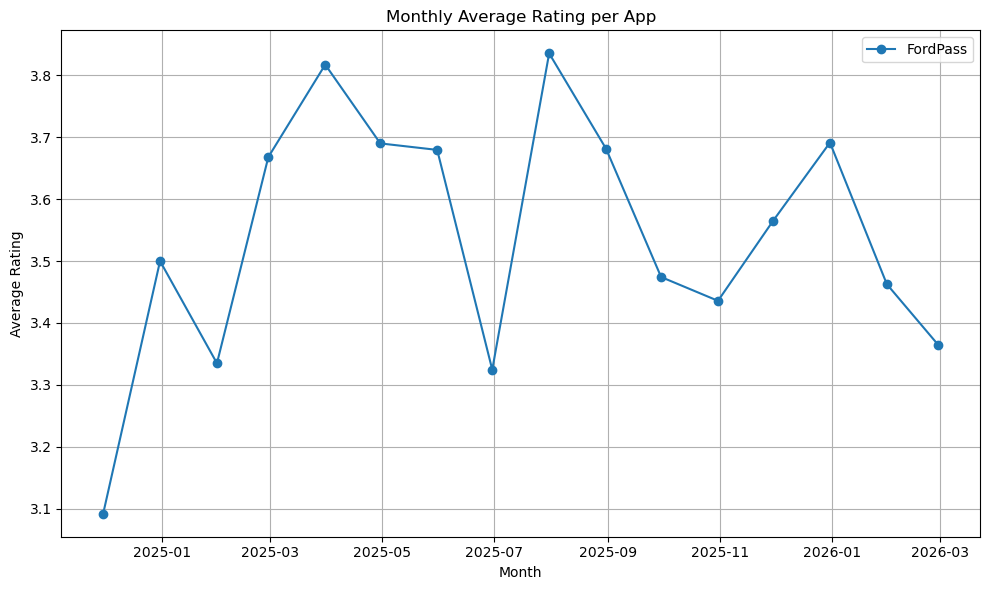

In [8]:
# Monthly average rating per app (line plot)
df['review_date'] = pd.to_datetime(df.get('review_date', df.get('at')), errors='coerce')
monthly = df.dropna(subset=['review_date']).groupby([pd.Grouper(key='review_date', freq='M'), 'app_name'])['rating'].mean().reset_index()
pivot = monthly.pivot(index='review_date', columns='app_name', values='rating')
plt.figure(figsize=(10,6))
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], marker='o', label=col)
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.title('Monthly Average Rating per App')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

def print_all_words_with_weights(model, feature_names):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic #{topic_idx+1}:")
        for i in topic.argsort()[::-1]:
            print(f"{feature_names[i]}: {topic[i]:.4f}")

def lda_topic_modeling(df, text_col, n_topics=3, n_top_words=10, show_all_weights=False):
    texts = df[text_col].astype(str).values
    vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
    X = vectorizer.fit_transform(texts)
    if X.shape[0] < n_topics:
        print("Not enough documents for topic modeling.")
        return None, None, None
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X)
    print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words)
    if show_all_weights:
        print_all_words_with_weights(lda, vectorizer.get_feature_names_out())
    return lda, vectorizer, X

# Example usage:
lda, vectorizer, X = lda_topic_modeling(ford_df, 'review_text', n_topics=10, n_top_words=10, show_all_weights=True)

Topic #1:
app features ford vehicle feature charge lighting zone removed add

Topic #2:
love app ford convenient excellent oil features useful life car

Topic #3:
good app far work amazing does ford car ok little

Topic #4:
start remote app car vehicle unlock lock truck love able

Topic #5:
app use easy vehicle phone open just like watch ford

Topic #6:
update app location vehicle version updated doesn work new better

Topic #7:
works time work doesn app like cool just use pretty

Topic #8:
app working phone nice car just control screen climate update

Topic #9:
great app ford awesome works best service pass free new

Topic #10:
car app service keeps won ford set connect turn truck


Topic #1:
app: 357.3442
features: 284.5617
ford: 185.3972
vehicle: 142.9746
feature: 128.4006
charge: 124.9141
lighting: 123.5235
zone: 121.1399
removed: 98.1890
add: 95.9589
service: 89.0978
control: 87.0354
just: 86.6786
charging: 81.1762
ability: 73.0265
truck: 72.7898
like: 66.8382
away: 65.8883
power:

In [11]:
# Hyperparameter tuning for LDA using perplexity score
import warnings
warnings.filterwarnings('ignore')

def tune_lda_hyperparameters(df, text_col, n_topics_range=[3, 5, 7, 10], alpha_range=['symmetric', 0.01, 0.1], beta_range=[0.01, 0.1, 'auto']):
    """
    Tune LDA hyperparameters and find the best combination using perplexity score (lower is better).
    """
    texts = df[text_col].astype(str).values
    vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
    X = vectorizer.fit_transform(texts)
    
    best_perplexity = float('inf')
    best_params = {}
    results = []
    
    for n_topics in n_topics_range:
        for alpha in alpha_range:
            for beta in beta_range:
                try:
                    lda = LatentDirichletAllocation(
                        n_components=n_topics,
                        doc_topic_prior=alpha,
                        topic_word_prior=beta,
                        max_iter=20,
                        random_state=42,
                        n_jobs=-1
                    )
                    lda.fit(X)
                    
                    # Calculate perplexity score (lower is better)
                    perplexity = lda.perplexity(X)
                    
                    results.append({
                        'n_topics': n_topics,
                        'alpha': alpha,
                        'beta': beta,
                        'perplexity': perplexity
                    })
                    
                    if perplexity < best_perplexity:
                        best_perplexity = perplexity
                        best_params = {'n_topics': n_topics, 'alpha': alpha, 'beta': beta, 'perplexity': perplexity}
                        
                except Exception as e:
                    print(f"Error with n_topics={n_topics}, alpha={alpha}, beta={beta}: {e}")
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('perplexity', ascending=True)
    
    print("\nTop 10 hyperparameter combinations (lower perplexity is better):")
    print(results_df.head(10))
    print(f"\nBest hyperparameters: {best_params}")
    
    return best_params, results_df

# Run hyperparameter tuning
best_params, tuning_results = tune_lda_hyperparameters(ford_df, 'review_text', n_topics_range=[3, 5, 7], alpha_range=['symmetric', 0.01], beta_range=[0.01, 0.1])

Error with n_topics=3, alpha=symmetric, beta=0.01: The 'doc_topic_prior' parameter of LatentDirichletAllocation must be None or a float in the range [0.0, 1.0]. Got 'symmetric' instead.
Error with n_topics=3, alpha=symmetric, beta=0.1: The 'doc_topic_prior' parameter of LatentDirichletAllocation must be None or a float in the range [0.0, 1.0]. Got 'symmetric' instead.
Error with n_topics=5, alpha=symmetric, beta=0.01: The 'doc_topic_prior' parameter of LatentDirichletAllocation must be None or a float in the range [0.0, 1.0]. Got 'symmetric' instead.
Error with n_topics=5, alpha=symmetric, beta=0.1: The 'doc_topic_prior' parameter of LatentDirichletAllocation must be None or a float in the range [0.0, 1.0]. Got 'symmetric' instead.
Error with n_topics=7, alpha=symmetric, beta=0.01: The 'doc_topic_prior' parameter of LatentDirichletAllocation must be None or a float in the range [0.0, 1.0]. Got 'symmetric' instead.
Error with n_topics=7, alpha=symmetric, beta=0.1: The 'doc_topic_prior' 

In [ ]:
# Train LDA with best hyperparameters
print(f"Training LDA with best hyperparameters: {best_params}")
print("="*60)

texts = ford_df['review_text'].astype(str).values
vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
X = vectorizer.fit_transform(texts)

# Extract best parameters
best_n_topics = best_params['n_topics']
best_alpha = best_params['alpha']
best_beta = best_params['beta']

# Train final model with best hyperparameters
best_lda = LatentDirichletAllocation(
    n_components=best_n_topics,
    doc_topic_prior=best_alpha,
    topic_word_prior=best_beta,
    max_iter=50,  # Increase iterations for better convergence
    random_state=42,
    n_jobs=-1
)
best_lda.fit(X)

print(f"\nTop words for each topic (using best hyperparameters):")
print("="*60)
print_top_words(best_lda, vectorizer.get_feature_names_out(), n_top_words=15)

print(f"\nAll words with weights (using best hyperparameters):")
print("="*60)
print_all_words_with_weights(best_lda, vectorizer.get_feature_names_out())